## Clustering of metabolomic data

also check out http://www.kodama-project.com/tutorial.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
#read the data, encode metabolites
xl = pd.ExcelFile('PMID_26088811_SI.xls')
pos = xl.parse('dataMatrix_pos')
neg = xl.parse('dataMatrix_neg')
sam = xl.parse('sampleMetadata')
met = xl.parse('metaboliteMetadata')

L1 = met[met['Annot. level'] == 1].copy()
L1['M'] = ["M%.2d" % i for i in range(len(L1))]
mcodes = L1.M.to_dict()

df_all = pd.concat([pos, neg], axis=1)
df = pd.concat([sam, df_all[L1.index]], axis=1)
# df.rename(columns=mcodes, inplace=True)

In [3]:
names = list(df.rename(columns=mcodes).columns)
i = -1
while i < (len(names)-1):
    if names[i] == names[i+1]:
        names[i] += 'P'
        names[i+1] += 'N'
        i += 1
    elif df.columns[i] in pos.columns:
        names[i] += 'P'
    elif df.columns[i] in neg.columns:
        names[i] += 'N'
    i += 1
df.columns = names

In [4]:
#L1[L1.index.str.contains('ster', case=False)]
#[k for k, v in mcodes.items() if v == 'M19']

### Warmup: PCA, kNN on Gender

In [5]:
from sklearn.preprocessing import StandardScaler
features = df.columns[df.columns.str.contains('M[0-9][0-9]')]

# Separating out the features
x = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['Gender']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
finalDf = pd.concat([df['Gender'].reset_index(drop=True), principalDf], axis = 1)

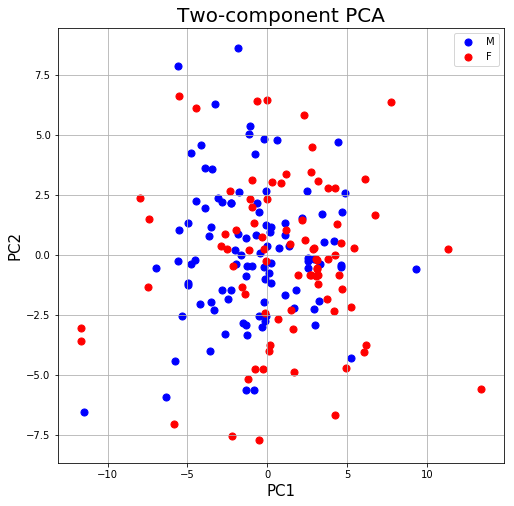

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('Two-component PCA', fontsize = 20)

targets = ['M', 'F']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Gender'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

In [8]:
# pretty lowsy!
pca.explained_variance_ratio_

array([0.14806311, 0.09313664])

### KNN

In [9]:
from sklearn.model_selection import train_test_split  
x = df.loc[:, features].values
y = df.Gender.replace({'M': 0, 'F': 1}).values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)  

In [10]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [11]:
y_pred = classifier.predict(X_test)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))

[[31  2]
 [10 12]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        33
           1       0.86      0.55      0.67        22

   micro avg       0.78      0.78      0.78        55
   macro avg       0.81      0.74      0.75        55
weighted avg       0.80      0.78      0.77        55



### more to come...